In [1]:
from pyMouSh import MoulinShape, TimeStamps, Qin_constant, Qin_sinusoidal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from numpy.random import default_rng

from collections import defaultdict
#import pandas as pd
import pickle
import seaborn as sns

sns.set_theme(style="ticks", font_scale=1.25)

secinday = 24*3600

#color base of cubelix 
# color = sns.cubehelix_palette(n_colors=5)
c1=[0.9312692223325372, 0.8201921796082118, 0.7971480974663592]
c2=[0.8314793143949643, 0.5987041921652179, 0.6530062709235388]
c3=[0.6672565752652589, 0.40671838146419587, 0.5620016466433286]
c4=[0.43082755198027817, 0.24984535814964698, 0.44393960899639856]
c5=[0.1750865648952205, 0.11840023306916837, 0.24215989137836502]

# Calculate arrays for ploting

In [2]:

#temperature profile based of foxx data -- Lauren
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy()#np.array([ZERO_KELVIN, ZERO_KELVIN])

initial_subglacial_area = 1 
regional_surface_slope = 0.01
channel_length = 25e3
ice_thickness = 500
initial_head = ice_thickness


time_start = 0
time_end = time_start + 6*secinday # 10 days seems enough to equilibrate more the amplitude reduce 
timestep = 30*60 #seconds #timestep is longer to reduce the volume of data
time = TimeStamps(time_start,time_end,timestep)

# how many days to account for the calculation of the min and max of head
idx_nday = -1*48 #days*number of half an hour in a day
idx_nday_test = -2*48

mean_qin = 0.15
App_in = 0.11
H = 500

expected_head_amplitude = 50 # or 55 based of visual measurements of the head amplitude in JEME data
original_head_amplitude = 900#532.44 

#Import head measurement for JEME
jeme_moulin = pd.read_csv('Field_Data/head_jeme.csv')
jeme_moulin = jeme_moulin.dropna()
h_real = jeme_moulin.head_bed.to_numpy()
t_real = jeme_moulin.soy.to_numpy()



### Sensitivity to normalized diurnal meltwater input range NDMIR
~~meltwater input variability~~  

In [22]:
n_run_sim1 = 500 # <------
# create random numbers 
rng1 = default_rng()
rng2 = default_rng() 
rng3 = default_rng()
Qin_mean_run = 1 * rng1.random(n_run_sim1) # <------
Qin_amplitude_run = rng2.random(n_run_sim1) # <------
ice_thickness_run = np.ones(n_run_sim1)*700#300+700 * rng3.random(n_run_sim1)


#initialize variables for loop:
head_amp_sim1 = []
head_amp_sim1_test = []
meltwater_input_sim1 = []
Qin_amp_sim1 = []
Qin_mean_sim1 = []
ice_thickness_sim1 = []

for idx_run in np.arange(n_run_sim1):   
    meltwater_input_sim1 = Qin_sinusoidal(time, Qin_mean_run[idx_run], Qin_amplitude_run[idx_run])         
    moulin = MoulinShape(ice_thickness = ice_thickness_run[idx_run],
                        initial_head = initial_head,
                        initial_subglacial_area = initial_subglacial_area, 
                        channel_length = channel_length,
                        regional_surface_slope = regional_surface_slope,
                        temperature_profile = temperature_profile)
    
    print('run = ', idx_run, '/', n_run_sim1 )
    #only take values of amplitude smaller or equal to the mean
    if Qin_mean_run[idx_run]>=Qin_amplitude_run[idx_run]:    
               
        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim1[idx],
                            overflow = True,
                            subglacial_baseflow = 0) 
            
        ##save array for timeseries plot
        #meltwater_input.append(melt_in)   
        #head.append(moulin.dict['head'])

        
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
        #calculate head amplitude
        head_amp = np.max(head_portion) - np.min(head_portion) #m
        head_amp_test = np.max(head_portion_test) - np.min(head_portion_test)
        #if (abs(head_amp - head_amp_test) / head_amp_test)*100 < 1:
        head_amp_sim1.append(head_amp) #m
        head_amp_sim1_test.append(head_amp_test) #m
        #save variable for plot (so that all have the same index)
        Qin_amp_sim1.append(Qin_amplitude_run[idx_run])
        Qin_mean_sim1.append(Qin_mean_run[idx_run])
        ice_thickness_sim1.append(ice_thickness_run[idx_run])
#        else:
#            print('no equilibrium')
#            
#            plt.figure()
#            plt.subplot(3,1,1)
#            plt.plot(time/secinday,meltwater_input_sim1)
#            plt.ylabel('Qin')
#           plt.subplot(3,1,2)
#            plt.plot(time/secinday,moulin.dict['head'],linewidth=3, color='black')
#            plt.plot(time[idx_nday:-1]/secinday,moulin.dict['head'][idx_nday:-1], linestyle='--', color='green')
#            plt.ylabel('head')
#            plt.ylim([0,1000])
#            plt.subplot(3,1,3)
#            plt.plot(time/secinday,moulin.dict['subglacial_radius'],linewidth=3, color='black')
#            plt.plot(time[idx_nday:-1]/secinday,moulin.dict['subglacial_radius'][idx_nday:-1], linestyle='--', color='green')
#            plt.ylabel('radius')
#            plt.savefig('tester\qin_H%d_num%s' %(ice_thickness_run[idx_run],idx_run))

with open('Pickles_TC/NDMIR_raw_700.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([head_amp_sim1,Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test], f)



run =  0 / 500
run =  1 / 500
run =  2 / 500
run =  3 / 500
run =  4 / 500
run =  5 / 500
run =  6 / 500
run =  7 / 500
run =  8 / 500
run =  9 / 500
run =  10 / 500
run =  11 / 500
run =  12 / 500
run =  13 / 500
run =  14 / 500
run =  15 / 500
run =  16 / 500
run =  17 / 500
run =  18 / 500
run =  19 / 500
run =  20 / 500
run =  21 / 500
run =  22 / 500
run =  23 / 500
run =  24 / 500
run =  25 / 500
run =  26 / 500
run =  27 / 500
run =  28 / 500
run =  29 / 500
run =  30 / 500
run =  31 / 500
run =  32 / 500
run =  33 / 500
run =  34 / 500
run =  35 / 500
run =  36 / 500
run =  37 / 500
run =  38 / 500
run =  39 / 500
run =  40 / 500
run =  41 / 500
run =  42 / 500
run =  43 / 500
run =  44 / 500
run =  45 / 500
run =  46 / 500
run =  47 / 500
run =  48 / 500
run =  49 / 500
run =  50 / 500
run =  51 / 500
run =  52 / 500
run =  53 / 500
run =  54 / 500
run =  55 / 500
run =  56 / 500
run =  57 / 500
run =  58 / 500
run =  59 / 500
run =  60 / 500
run =  61 / 500
run =  62 / 500
ru

run =  489 / 500
run =  490 / 500
run =  491 / 500
run =  492 / 500
run =  493 / 500
run =  494 / 500
run =  495 / 500
run =  496 / 500
run =  497 / 500
run =  498 / 500
run =  499 / 500


### Sensitivity to mean baseflow

In [64]:
n_run_sim2 = 400

# create random numbers 
rng1 = default_rng()
rng2 = default_rng() 

bf_mean_run = 5 * rng1.random(n_run_sim2) # <------
ice_thickness_run = np.ones(n_run_sim1)*500#300+700 * rng2.random(n_run_sim2)

#initialize variables for loop:
bf_mean_sim2      = []
ice_thickness_sim2 = []
head_amp_sim2 = []
head_amp_test_sim2 = []


meltwater_input = Qin_sinusoidal(time, mean_qin, App_in)

for idx_run in np.arange(n_run_sim2):        
    moulin = MoulinShape(ice_thickness = ice_thickness_run[idx_run],
                          initial_head = initial_head,
                          initial_subglacial_area = initial_subglacial_area, 
                          channel_length = channel_length,
                          regional_surface_slope = regional_surface_slope,
                          temperature_profile = temperature_profile)
        
    for idx,t in enumerate(time) :
        moulin.run1step(time,
                        timestep,
                        meltwater_input[idx],
                        overflow = True,
                        subglacial_baseflow = bf_mean_run[idx_run])         
    #head.append(moulin.dict['head'])
    head_portion = moulin.dict['head'][idx_nday:-1]
    head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
    #calculate head amplitude
    head_amp_sim2.append(np.max(head_portion) - np.min(head_portion)) 
    head_amp_test_sim2.append(np.max(head_portion_test) - np.min(head_portion_test))
    #save variables
    bf_mean_sim2.append(bf_mean_run[idx_run])
    ice_thickness_sim2.append(ice_thickness_run[idx_run])
    
with open('Pickles_TC/MeanBF_500.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([head_amp_sim2,bf_mean_sim2, ice_thickness_sim2,head_amp_test_sim2,bf_mean_run,ice_thickness_run], f)
    


## lags with fixe Abf and variable Qbf

In [5]:
#n_run_sim5 = 5
#A_bf_star = 0.5
bf_mean_run_sim5 = [0.25,0.5,1,1.5,2]#np.linspace(0.5,1,n_run_sim5)
bf_amplitude_run = App_in


lags_sim5 = np.linspace(0,13,20)
meltwater_input_sim5 = Qin_sinusoidal(time, mean_qin, App_in)

#initialize
head_amplitude = np.zeros(len(lags_sim5))
head_amplitude_test = np.zeros(len(lags_sim5))
head_amp_lag_sim5 = np.zeros([len(bf_mean_run_sim5),len(lags_sim5)]) #row,column
head_amp_lag_test_sim5 = np.zeros([len(bf_mean_run_sim5),len(lags_sim5)])
bf_mean_sim5 = []
bf_amplitude_sim5 = []
lags_array_sim5 = []

for idx_run in np.arange(len(bf_mean_run_sim5)):
    #only take values of amplitude smaller or equal to the mean
    #if bf_mean_run_sim5[idx_run]>=2*bf_amplitude_run[idx_run]:  
    print('run = ', idx_run, '/', len(bf_mean_run_sim5) )
    for idx_lag,lag in enumerate(lags_sim5):
        baseflow_sim5 = Qin_sinusoidal(time, bf_mean_run_sim5[idx_run], bf_amplitude_run,shift=lag*3600) #mean,amplitude
        moulin = MoulinShape(ice_thickness = ice_thickness,
                              initial_head = initial_head,
                              initial_subglacial_area = initial_subglacial_area, 
                              channel_length = channel_length,
                              regional_surface_slope = regional_surface_slope,
                              temperature_profile = temperature_profile)

        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim5[idx],
                            overflow = True,
                            subglacial_baseflow = baseflow_sim5[idx])         
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
        #calculate head amplitude
        head_amplitude_test[idx_lag] = np.max(head_portion_test) - np.min(head_portion_test)      
        head_amplitude[idx_lag] = np.max(head_portion) - np.min(head_portion)#m
    
    lags_array_sim5.append(lags_sim5)
    head_amp_lag_sim5[idx_run] = head_amplitude
    head_amp_lag_test_sim5[idx_run] = head_amplitude_test
    #percent_head_lag[idx_run] = head_amp_lag - head_amp_lag[0]
    bf_amplitude_sim5.append(bf_amplitude_run)
    bf_mean_sim5.append(bf_mean_run_sim5[idx_run])

with open('Pickles_TC/lag.pkl', 'wb') as f: 
    pickle.dump([bf_amplitude_sim5,bf_mean_sim5,head_amp_lag_sim5,head_amp_lag_test_sim5,lags_array_sim5], f)       

run =  0 / 5
run =  1 / 5
run =  2 / 5
run =  3 / 5
run =  4 / 5


# Plot 3 panel

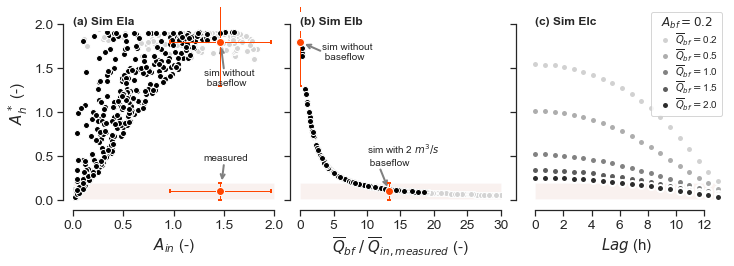

In [40]:
# Getting back the objects:
with open('Pickles_TC/MeanBF_500.pkl', 'rb') as f: 
    head_amp_sim2,bf_mean_sim2, ice_thickness_sim2,head_amp_test_sim2,bf_mean_run,ice_thickness_run = pickle.load(f)
    
# Getting back the objects:
with open('Pickles_TC/NDMIR_raw_500_good.pkl', 'rb') as f: 
    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)
    
    # Getting back the objects:
with open('Pickles_TC/lag.pkl', 'rb') as f: 
    bf_amplitude_sim5,bf_mean_sim5,head_amp_lag_sim5,head_amp_lag_test_sim5,lags_array_sim5 = pickle.load(f)


fig, (ax1,ax2,ax5) = plt.subplots(1,3,figsize=(10,3.5),sharey=True)

ax1.fill_between([0,2], 10/H,100/H, facecolor = c1, alpha = 0.3,zorder=0) 

for idx in np.arange(len(Qin_amp_sim1)):
    Qin_amp = np.array(Qin_amp_sim1)
    Qin_mean = np.array(Qin_mean_sim1)
    head_amp = np.array(head_amp_sim1)
    if (abs(head_amp_sim1[idx] - head_amp_sim1_test[idx]) / head_amp_sim1_test[idx])*100 <=5:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=1,#*100,/expected_head_amplitude
             linestyle='',marker='o',markeredgecolor='white', color='black')
    if (abs(head_amp_sim1[idx] - head_amp_sim1_test[idx]) / head_amp_sim1_test[idx])*100 >5:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=0,#*100,/expected_head_amplitude
             linestyle='',marker='o',markeredgecolor='white', color='lightgrey')

ax1.errorbar(App_in*2/mean_qin,original_head_amplitude/H, xerr=0.5, yerr=0.5,fmt='--o',
             markeredgecolor='white', color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', markersize= 8, capsize=2, capthick=2)

ax1.errorbar(App_in*2/mean_qin,expected_head_amplitude/H, xerr=0.5, yerr=0.1,fmt='--o',
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', capsize=2, capthick=2)

ax1.set_xlim([0,2])
ax1.set_ylim([0,2.2])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.set_ylabel('$A_h^*$ (-)')#('$h^{\'}$ (-)')
ax1.set_xlabel('$A_{in}^*$ (-)')#('bf_amplitude/bf_mean')#'Meltwater input variability (-)'
sns.despine(offset=[10,10],trim=True, ax=ax1)

ax1.add_artist(ConnectionPatch((1.5,1.5),(App_in*2/mean_qin,original_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(1.3,1.3,'sim without\n baseflow',fontsize=10)

ax1.add_artist(ConnectionPatch((1.5,0.4),(App_in*2/mean_qin,0.09),'data','data', shrinkB=12,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(1.3,0.45,'measured',fontsize=10)


ax2.fill_between([0,30], 10/500,100/500, facecolor = c1, alpha = 0.3,zorder=0) 

for idx in np.arange(len(bf_mean_sim2)):
    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 <=5:
        ax2.plot(bf_mean_sim2[idx]/mean_qin,
                (head_amp_sim2[idx])/500,#*100, 
                 linestyle='',marker='o',markeredgecolor='white', color='black', zorder=1)
    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 >5:
        ax2.plot(bf_mean_sim2[idx]/mean_qin,
                (head_amp_sim2[idx])/500,#*100, 
                 linestyle='',marker='o',markeredgecolor='white', color='lightgrey', zorder=0)
        
#ax2.plot(3/0.3,expected_head_amplitude/500,marker='o', markeredgewidth=2,markeredgecolor='red', color='black')
ax2.errorbar(0,original_head_amplitude/H, yerr=0.5,fmt='--o',clip_on=False,
             markeredgecolor='white', color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', markersize= 8, capsize=2, capthick=2)
ax2.errorbar(2/mean_qin,expected_head_amplitude/H,  yerr=0.1,fmt='--o',clip_on=False,
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', capsize=2, capthick=2)
#ax2.plot([0,17],[1,1], linestyle='--', color='darkgrey')
#ax2.set_ylabel('% measured head amplitude (m)')
#ax2.set_ylabel('$A_h\;/\;H$ (-)')#('$h^{\'}$ (-)')
ax2.set_xlabel('$\overline{Q}_{bf}\; /\; \overline{Q}_{in,measured}$ (-)')#Mean baseflow (Mean $Q_{in}$ equivalent)')#('bf_amplitude/bf_mean')
ax2.set_xticks(np.arange(0,31,5))
#Relative mean baseflow \n(mean $Q_{in}$ equivalent)
#ax2.set_ylim([0,300])
#ax.legend()
#ax2.set_ylim([0,1.5])
ax2.set_xlim([-0.1,30])
sns.despine(offset=[10,10],trim=True, ax=ax2)

ax2.add_artist(ConnectionPatch((3,1.7),(0,original_head_amplitude/H),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(3.2,1.6,'sim without\n baseflow',fontsize=10)

ax2.add_artist(ConnectionPatch((12,0.35),(2/mean_qin,expected_head_amplitude/H),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(10,0.4,'sim with 2 $m^3/s$\n baseflow',fontsize=10)




color = sns.color_palette('Greys', len(bf_mean_sim5)+1)
#color = sns.cubehelix_palette(n_colors=len(bf_mean_sim5))

ax5.fill_between([0,13], 10/500,100/500, facecolor = c1, alpha = 0.3,zorder=0) 
for idx in np.arange(len(bf_mean_sim5)):
    ax5.plot(lags_array_sim5[idx],head_amp_lag_sim5[idx]/500,'o',
             label='$\overline{Q}_{bf}=$%.1f'%(bf_mean_sim5[idx]),
             color=color[idx+1],markeredgecolor='white',markeredgewidth=2, markersize=7)
#ax4.plot([1,1],[0,100],color='darkgrey',linestyle='dotted')
#ax5.set_ylabel('$A_{h}\;/\;H$ (-)')
ax5.set_xlabel('$Lag$ (h)')#Amplitude baseflow (Qin amplitude equivalent) (-)')
ax5.set_xticks(np.arange(0,13,2))
#ax5.set_ylim([0,1.5])
#ax5.set_xlim([0,15])
sns.despine(offset=[10,10],trim=True, ax=ax5)

#letters
ax1.text(0,2,'(a) Sim EIa',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0,2,'(b) Sim EIb',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax5.text(0,2,'(c) Sim EIc',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax5.legend( loc=1,  labelspacing=0, handletextpad=0.01,  
           prop={'size': 10}, title='$A_{bf}=0.2$',title_fontsize=12, bbox_to_anchor=(1, 1))

fig.tight_layout(pad=0)


plt.savefig('Figure_TC/Corr_3panels_H500.pdf',bbox_inches = 'tight')

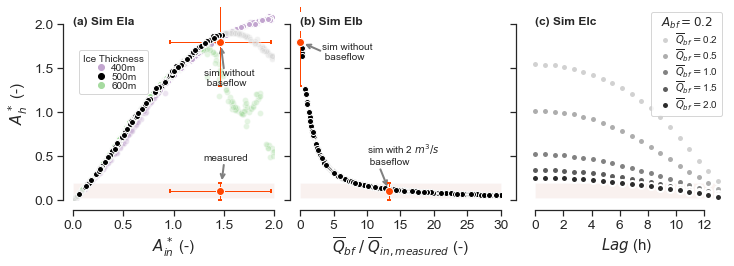

In [41]:
# Getting back the objects for panel a

# Getting back the objects:
with open('Pickles_TC/MeanBF_500.pkl', 'rb') as f: 
    head_amp_sim2,bf_mean_sim2, ice_thickness_sim2,head_amp_test_sim2,bf_mean_run,ice_thickness_run = pickle.load(f)

    
    # Getting back the objects:
with open('Pickles_TC/lag.pkl', 'rb') as f: 
    bf_amplitude_sim5,bf_mean_sim5,head_amp_lag_sim5,head_amp_lag_test_sim5,lags_array_sim5 = pickle.load(f)


fig, (ax1,ax2,ax5) = plt.subplots(1,3,figsize=(10,3.5),sharey=True)
colors_sim1=['#c2a5cf','black','#a6dba0']
#colors_sim1=['#c2a5cf','#7b3294','black','#008837','#a6dba0']

ax1.fill_between([0,2], 10/H,100/H, facecolor = c1, alpha = 0.3,zorder=0) 

#with open('Pickles_TC/NDMIR_raw_300.pkl', 'rb') as f: 
#    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)

#for idx in np.arange(len(Qin_amp_sim1)):
    
#    Qin_amp = np.array(Qin_amp_sim1)
#    Qin_mean = np.array(Qin_mean_sim1)
#    head_amp = np.array(head_amp_sim1)
#    head_amp_test = np.array(head_amp_sim1_test)
#    if (abs(head_amp[idx] - head_amp_test[idx]) / head_amp_test[idx])*100 <=2:
#        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
#                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=0,
#             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[0])
#    else:
#        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
#                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=0,
#             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[0],alpha=0.3)
        

with open('Pickles_TC/NDMIR_raw_400.pkl', 'rb') as f: 
    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)

for idx in np.arange(len(Qin_amp_sim1)):
    
    Qin_amp = np.array(Qin_amp_sim1)
    Qin_mean = np.array(Qin_mean_sim1)
    head_amp = np.array(head_amp_sim1)
    head_amp_test = np.array(head_amp_sim1_test)
    if (abs(head_amp[idx] - head_amp_test[idx]) / head_amp_test[idx])*100 <=2:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=1,
             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[0])
    else:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=1,
             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[0],alpha=0.3)
with open('Pickles_TC/NDMIR_raw_500.pkl', 'rb') as f: 
    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)

for idx in np.arange(len(Qin_amp_sim1)):
    
    Qin_amp = np.array(Qin_amp_sim1)
    Qin_mean = np.array(Qin_mean_sim1)
    head_amp = np.array(head_amp_sim1)
    head_amp_test = np.array(head_amp_sim1_test)
    if (abs(head_amp[idx] - head_amp_test[idx]) / head_amp_test[idx])*100 <=2:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=3,
             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[1])
    else:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=2,
             linestyle='',marker='o',markeredgecolor='white', color='lightgrey',alpha=0.3)        
        
with open('Pickles_TC/NDMIR_raw_600.pkl', 'rb') as f: 
    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)

for idx in np.arange(len(Qin_amp_sim1)):
    
    Qin_amp = np.array(Qin_amp_sim1)
    Qin_mean = np.array(Qin_mean_sim1)
    head_amp = np.array(head_amp_sim1)
    head_amp_test = np.array(head_amp_sim1_test)
    if (abs(head_amp[idx] - head_amp_test[idx]) / head_amp_test[idx])*100 <=2:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=1,
             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[2])
    else:
        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=1,
             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[2],alpha=0.3)
        
        
#with open('Pickles_TC/NDMIR_raw_700.pkl', 'rb') as f: 
#    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1, head_amp_sim1_test = pickle.load(f)

#for idx in np.arange(len(Qin_amp_sim1)):
    
#    Qin_amp = np.array(Qin_amp_sim1)
#    Qin_mean = np.array(Qin_mean_sim1)
#    head_amp = np.array(head_amp_sim1)
#    head_amp_test = np.array(head_amp_sim1_test)
#    if (abs(head_amp[idx] - head_amp_test[idx]) / head_amp_test[idx])*100 <=2:
#        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
#                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=0,
#             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[4])
#    else:
#        ax1.plot(Qin_amp[idx]*2/Qin_mean[idx],
#                 (head_amp[idx]/ice_thickness_sim1[idx]),zorder=0,
#             linestyle='',marker='o',markeredgecolor='white', color=colors_sim1[4],alpha=0.3)
        

elements = [Line2D([0], [0], marker='o', color=colors_sim1[0], lw=0, label='400m'),
            Line2D([0], [0], marker='o', color=colors_sim1[1], lw=0, label='500m'),
            Line2D([0], [0], marker='o', color=colors_sim1[2], lw=0, label='600m')]

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax1.legend(handles=elements, loc=0,  labelspacing=0, handletextpad=0.01,  
           prop={'size': 10}, title='Ice Thickness',title_fontsize=10, bbox_to_anchor=(0.4, 0.8))
       
        
    


ax1.errorbar(App_in*2/mean_qin,original_head_amplitude/H, xerr=0.5, yerr=0.5,fmt='--o',
             markeredgecolor='white', color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', markersize= 8, capsize=2, capthick=2)

ax1.errorbar(App_in*2/mean_qin,expected_head_amplitude/H, xerr=0.5, yerr=0.1,fmt='--o',
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', capsize=2, capthick=2)

ax1.set_xlim([0,2])
ax1.set_ylim([0,2.2])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.set_ylabel('$A_h^*$ (-)')#('$h^{\'}$ (-)')
ax1.set_xlabel('$A_{in}^*$ (-)')#('bf_amplitude/bf_mean')#'Meltwater input variability (-)'
sns.despine(offset=[10,10],trim=True, ax=ax1)

ax1.add_artist(ConnectionPatch((1.5,1.5),(App_in*2/mean_qin,original_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(1.3,1.3,'sim without\n baseflow',fontsize=10)

ax1.add_artist(ConnectionPatch((1.5,0.4),(App_in*2/mean_qin,0.09),'data','data', shrinkB=12,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(1.3,0.45,'measured',fontsize=10)


ax2.fill_between([0,30], 10/500,100/500, facecolor = c1, alpha = 0.3,zorder=0) 

for idx in np.arange(len(bf_mean_sim2)):
#    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 <=5:
    ax2.plot(bf_mean_sim2[idx]/mean_qin,
                (head_amp_sim2[idx])/500,#*100, 
                 linestyle='',marker='o',markeredgecolor='white', color='black', zorder=1)
#    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 >5:
#        ax2.plot(bf_mean_sim2[idx]/mean_qin,
#                (head_amp_sim2[idx])/500,#*100, 
#                 linestyle='',marker='o',markeredgecolor='white', color='lightgrey', zorder=0)
        
#ax2.plot(3/0.3,expected_head_amplitude/500,marker='o', markeredgewidth=2,markeredgecolor='red', color='black')
ax2.errorbar(0,original_head_amplitude/H, yerr=0.5,fmt='--o',clip_on=False,
             markeredgecolor='white', color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', markersize= 8, capsize=2, capthick=2)
ax2.errorbar(2/mean_qin,expected_head_amplitude/H,  yerr=0.1,fmt='--o',clip_on=False,
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', capsize=2, capthick=2)
#ax2.plot([0,17],[1,1], linestyle='--', color='darkgrey')
#ax2.set_ylabel('% measured head amplitude (m)')
#ax2.set_ylabel('$A_h\;/\;H$ (-)')#('$h^{\'}$ (-)')
ax2.set_xlabel('$\overline{Q}_{bf}\; /\; \overline{Q}_{in,measured}$ (-)')#Mean baseflow (Mean $Q_{in}$ equivalent)')#('bf_amplitude/bf_mean')
ax2.set_xticks(np.arange(0,31,5))
#Relative mean baseflow \n(mean $Q_{in}$ equivalent)
#ax2.set_ylim([0,300])
#ax.legend()
#ax2.set_ylim([0,1.5])
ax2.set_xlim([-0.1,30])
sns.despine(offset=[10,10],trim=True, ax=ax2)

ax2.add_artist(ConnectionPatch((3,1.7),(0,original_head_amplitude/H),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(3.2,1.6,'sim without\n baseflow',fontsize=10)

ax2.add_artist(ConnectionPatch((12,0.35),(2/mean_qin,expected_head_amplitude/H),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(10,0.4,'sim with 2 $m^3/s$\n baseflow',fontsize=10)




color = sns.color_palette('Greys', len(bf_mean_sim5)+1)
#color = sns.cubehelix_palette(n_colors=len(bf_mean_sim5))

ax5.fill_between([0,13], 10/500,100/500, facecolor = c1, alpha = 0.3,zorder=0) 
for idx in np.arange(len(bf_mean_sim5)):
    ax5.plot(lags_array_sim5[idx],head_amp_lag_sim5[idx]/500,'o',
             label='$\overline{Q}_{bf}=$%.1f'%(bf_mean_sim5[idx]),
             color=color[idx+1],markeredgecolor='white',markeredgewidth=2, markersize=7)
#ax4.plot([1,1],[0,100],color='darkgrey',linestyle='dotted')
#ax5.set_ylabel('$A_{h}\;/\;H$ (-)')
ax5.set_xlabel('$Lag$ (h)')#Amplitude baseflow (Qin amplitude equivalent) (-)')
ax5.set_xticks(np.arange(0,13,2))
#ax5.set_ylim([0,1.5])
#ax5.set_xlim([0,15])
sns.despine(offset=[10,10],trim=True, ax=ax5)

#letters
ax1.text(0,2,'(a) Sim EIa',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax2.text(0,2,'(b) Sim EIb',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))
ax5.text(0,2,'(c) Sim EIc',fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='white'))

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax5.legend( loc=1,  labelspacing=0, handletextpad=0.01,  
           prop={'size': 10}, title='$A_{bf}=0.2$',title_fontsize=12, bbox_to_anchor=(1, 1))

fig.tight_layout(pad=0)


plt.savefig('Figure_TC/Corr_3panels.pdf',bbox_inches = 'tight')

# Sensitivity to lags

In [25]:
n_run_sim4 = 500 # <------
# create random numbers 
rng1 = default_rng()
rgn2 = default_rng() 
bf_mean_run = 1 * rng1.random(n_run_sim4)+1 # <------
bf_amplitude_run = 0.22 * rgn2.random(n_run_sim4) # <------


lags_sim4 = [0,3,6,9,12]#np.arange(0,13,2)

meltwater_input_sim4 = Qin_sinusoidal(time, mean_qin, App_in)

#initialize
head_amplitude = np.zeros(len(lags_sim4))
head_amplitude_test = np.zeros(len(lags_sim4))
head_amp_lag_sim4 = np.zeros([n_run_sim4,len(lags_sim4)]) #row,column
head_amp_lag_test_sim4 = np.zeros([n_run_sim4,len(lags_sim4)])
bf_mean_sim4 = []
bf_amplitude_sim4 = []

for idx_run in np.arange(n_run_sim4):
    #only take values of amplitude smaller or equal to the mean
    #if bf_mean_run[idx_run]>=2*bf_amplitude_run[idx_run]:  
    print('run = ', idx_run, '/', n_run_sim4 )
    for idx_lag,lag in enumerate(lags_sim4):
        baseflow_sim4 = Qin_sinusoidal(time, bf_mean_run[idx_run], bf_amplitude_run[idx_run],shift=lag*3600) #mean,amplitude
        moulin = MoulinShape(ice_thickness = ice_thickness,
                              initial_head = initial_head,
                              initial_subglacial_area = initial_subglacial_area, 
                              channel_length = channel_length,
                              regional_surface_slope = regional_surface_slope,
                              temperature_profile = temperature_profile)

        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim4[idx],
                            overflow = True,
                            subglacial_baseflow = baseflow_sim4[idx])         
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
        #calculate head amplitude
        head_amplitude_test[idx_lag] = np.max(head_portion_test) - np.min(head_portion_test)      
        head_amplitude[idx_lag] = np.max(head_portion) - np.min(head_portion)#m
           
    head_amp_lag_sim4[idx_run] = head_amplitude
    head_amp_lag_test_sim4[idx_run] = head_amplitude_test
    #percent_head_lag[idx_run] = head_amp_lag - head_amp_lag[0]
    bf_amplitude_sim4.append(bf_amplitude_run[idx_run])
    bf_mean_sim4.append(bf_mean_run[idx_run])

with open('Pickles_TC/lag_single.pkl', 'wb') as f: 
    pickle.dump([bf_amplitude_sim4,bf_mean_sim4,head_amp_lag_sim4,head_amp_lag_test_sim4], f)       

run =  0 / 500
run =  1 / 500
run =  2 / 500
run =  3 / 500


KeyboardInterrupt: 

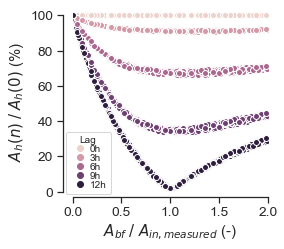

In [24]:
# Getting back the objects:
with open('Pickles_TC/lag_single.pkl', 'rb') as f: 
    bf_amplitude_sim4,bf_mean_sim4,head_amp_lag_sim4,head_amp_lag_test_sim4 = pickle.load(f)

#Lag -- timeseries for one baselfow mean

fig, ax4 = plt.subplots(figsize=(3.5,3.5))

#color = sns.color_palette('Greys', len(lags_sim4))
color = sns.cubehelix_palette(n_colors=len(lags_sim4))
for idx in np.arange(len(head_amp_lag_sim4)):
        percent_head_lag = (head_amp_lag_sim4[idx]/head_amp_lag_sim4[idx][0]) *100
        ratio_amplitude= (np.array(bf_amplitude_sim4[idx] )/App_in)
        for jdx in np.arange(len(lags_sim4)):
            #if (abs(head_amp_lag_test_sim4[idx][jdx] - head_amp_lag_sim4[idx][jdx]) 
            #    / head_amp_lag_sim4[idx][jdx]) * 100 <1:
            ax4.plot(ratio_amplitude,percent_head_lag[jdx], marker='o', 
                         markeredgecolor='white', color=color[jdx])#, label='lag=0h')
ax4.set_ylabel('$A_{h}(n)\;/\;A_{h}(0)$ (%)')
ax4.set_xlabel('$A_{bf}\;/\;A_{in,measured}$ (-)')#Amplitude baseflow (Qin amplitude equivalent) (-)')
ax4.set_xlim([0,2])
sns.despine(offset=[10,0],trim=True, ax=ax4)


elements = [Line2D([0], [0],  marker='o', color=color[0], lw=0, label='0h'),
            Line2D([0], [0],  marker='o', color=color[1], lw=0, label='3h'),
            Line2D([0], [0],  marker='o', color=color[2], lw=0, label='6h'),
            Line2D([0], [0],  marker='o', color=color[3], lw=0, label='9h'),
            Line2D([0], [0],  marker='o', color=color[4], lw=0, label='12h')]

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax4.legend(handles=elements, loc=0,  labelspacing=0, handletextpad=0.01,  
           prop={'size': 10}, title='Lag',title_fontsize=10, bbox_to_anchor=(0.22, 0.37))

plt.savefig('Figure_TC/Corr_lag.pdf',bbox_inches = 'tight')